# PaperPi Structure
Supervisor will loop and poll each plugin for an update. Plugins are all`Plugin()` objects with a `poll` method

When polled `Plugin()` objects respond with a structured list (tuple/dict) with the following information:
* Priority(`int`): 0 (high) -- 10+ (low); plugins with negative values are excluded
* Update Required(`bool`): True update; False do not update

Plugin objects require the following parameters:
* configuration(`dict`) argparse/config.ini style dict
* resolution (this may be pulled from the configuration?)
* name(`str`) human readable name for logging and reference
* update_function(`func`): function that will run and provide updates and status

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import logging.config
from itertools import cycle
from inspect import getfullargspec
from importlib import import_module
from time import sleep
import sys
from pathlib import Path
from os import chdir


In [3]:
import ArgConfigParse
from epdlib import Screen
from epdlib.Screen import Update
from library.CacheFiles import CacheFiles
from library.Plugin import Plugin
from library.InterruptHandler import InterruptHandler

import constants
import errors

In [4]:
logging.basicConfig(level=logging.INFO)

In [5]:
def do_exit(status=0, message=None):
    if message:
        if status > 0:
            logging.error(f'unexpected exit: {message}')
        border = '\n'+'#'*70 + '\n'
        message = border + message + border + '\n***Exiting***'
        print(message)
        
    try:
        sys.exit(status)
    except Exception as e:
        pass

In [6]:
f = Path('./paperpi.ini').resolve()
f

PosixPath('/home/pi/src/epd_display/paperpi/paperpi.ini')

In [7]:
sys.argv.append('-d')

In [8]:
def get_cmd_line_args():
    cmd_args = ArgConfigParse.CmdArgs()
    cmd_args.add_argument('-c', '-config', ignore_none=True, metavar='CONFIG_FILE.ini',
                         type=str, dest='user_config',
                         help='use the specified configuration file')
    
    cmd_args.add_argument('-l', '--log_level', ignore_none=True, metavar='LOG_LEVEL',
                         type=str, choices=['DEBUG', 'INFO', 'WARNING', 'ERROR'],
                         dest='main__log_level', help='change the log output level')
    
    cmd_args.add_argument('-d', '--daemon', required=False, default=False,
                         dest='main__daemon', action='store_true', 
                         help='run in daemon mode (ignore user configuration if found)')

   
    cmd_args.parse_args()
    return cmd_args
    
    

In [9]:
def get_config_files(cmd_args):
    config_files_list = [constants.config_base, constants.config_system, constants.config_user]
    
    if hasattr(cmd_args, "main__daemon"):
        if cmd_args.main_daemon:
            logging.debug('excluding user config files')
            config_files_list.pop()
    
    config_files = ArgConfigParse.ConfigFile(config_files_list, ignore_missing=True)
    config_files.parse_config()
    return config_files

In [ ]:
def build_plugin_loop(screen, config):
    pass

In [39]:
def main():
    # set the absolute path to the current directory
    absolute_path = constants.absolute_path
    
    # change directory into the current working directory
    # to simplify futher path related work
    chdir(absolute_path)
    
    # set up logging
    logging.config.fileConfig(constants.logging_config)
    logger = logging.getLogger(__name__)
    
    # get command line and config file arguments
    cmd_args = get_cmd_line_args()
    config_files = get_config_files(cmd_args)
    
    # merge file and commandline (right-most over-writes left)
    config = ArgConfigParse.merge_dict(config_files.config_dict, cmd_args.nested_opts_dict)

    logging.root.setLevel(config['main']['log_level'])
    
    # setup display
    try:
        logging.debug('setting display type')
        epd_module = '.'.join([constants.waveshare_epd, config['main']['display_type']])
        epd = import_module(epd_module)
    except KeyError as e:
        do_exit(1, errors.keyError_fmt.format('main', 'display_type'))
    except ModuleNotFoundError as e:
        do_exit(1, errors.moduleNotFoundError_fmt.format(config["main"]["display_type"], e))
        
    screen = Screen()
    try:
        screen.epd = epd
    except PermissionError as e:
        logging.critical(f'Error initializing EPD: {e}')
        logging.critical(f'The user executing {constants.app_name} does not have access to the SPI device.')
        do_exit(1, 'This user does not have access to the SPI group\nThis can typically be resolved by running:\n$ sudo groupadd <username> spi')

    try:
        config['main']['rotation'] = int(config['main']['rotation'])
    except KeyError as e:
        logging.info(errors.keyError_fmt.format('main', 'rotation'))
        logging.info('using default: 0')
    try:
        screen.rotation = config['main']['rotation']
    except ValueError as e:
        logging.error('invalid rotation; valid values are: 0, 90, -90, 180')
        do_exit(1, errors.keyError_fmt.format('main', 'rotation'))
    
    logging.debug('checking splash settings')
    if 'splash' in config['main']:
        logging.debug('checking splash screen settings')
        if config['main']['splash']:
            
            splash = True
        else:
            logging
            splash = False
    else:
        splash = True

    if splash:
        from plugins.splash_screen import splash_screen
        splash_config = { 
            'name': 'Splash Screen',
            'layout': splash_screen.layout.layout,
            'update_function': splash_screen.update_function,
            'resolution': screen.resolution
        } 
        logging.debug('configuring and displaying splash screen')
        splash = Plugin(**splash_config)
        splash.update(constants.app_name, constants.version, constants.url)
        screen.initEPD()
        screen.writeEPD(splash.image)
    

15:27:36 <ipython-input-39-2fe7bca1efc4>:main:24:DEBUG - setting display type
15:27:36 Screen:__init__:216:INFO - Screen created
15:27:36 Screen:rotation:273:DEBUG - Screen rotation set to: 0
15:27:36 epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
15:27:38 Screen:rotation:273:DEBUG - Screen rotation set to: 180
15:27:38 <ipython-input-39-2fe7bca1efc4>:main:51:DEBUG - checking splash settings
15:27:38 <ipython-input-39-2fe7bca1efc4>:main:53:DEBUG - checking splash screen settings
15:27:38 <ipython-input-39-2fe7bca1efc4>:main:71:DEBUG - configuring and displaying splash screen
15:27:38 Layout:__init__:151:DEBUG - creating layout
15:27:38 Layout:layout:186:DEBUG - calculating layout for resolution [600, 448]
15:27:38 Layout:layout:192:DEBUG - layout id(2942584464)
15:27:38 Layout:_calculate_layout:215:DEBUG - *****app_name*****
15:27:38 Layout:_check_keys:365:DEBUG - checking layout keys
15:27:38 Layout:_check_keys:370:DEBUG - adding key: maxchar: None
15:27:38 Layout:_che

15:27:40 Block:_text_formatter:499:DEBUG - formatting string: 0.0.1
15:27:40 Block:_text_formatter:502:DEBUG - formatted list:
 ['0.0.1']
15:27:40 Block:_text2image:513:DEBUG - creating blank image area: (600, 45) with inverse: False
15:27:40 Block:_text2image:528:DEBUG - line size: 57, 33
15:27:40 Block:_text2image:532:DEBUG - max x dim so far: 57
15:27:40 Block:_text2image:536:DEBUG - dimensions of text portion of image: (57, 33)
15:27:40 Block:_text2image:544:DEBUG - hcenter line: 0.0.1
15:27:40 Block:_text2image:546:DEBUG - drawing text at 0, 0
15:27:40 Block:_text2image:547:DEBUG - with dimensions: 57, 33
15:27:40 Block:_text2image:573:DEBUG - pasting text portion at coordinates: 272, 6
15:27:40 Layout:update_contents:388:DEBUG - updating block: url
15:27:40 Block:_text_formatter:499:DEBUG - formatting string: https://github.com/txoof/epd_display
15:27:40 Block:_text_formatter:502:DEBUG - formatted list:
 ['https://github.com/txoof/e', 'pd_display']
15:27:40 Block:_text2image:513:

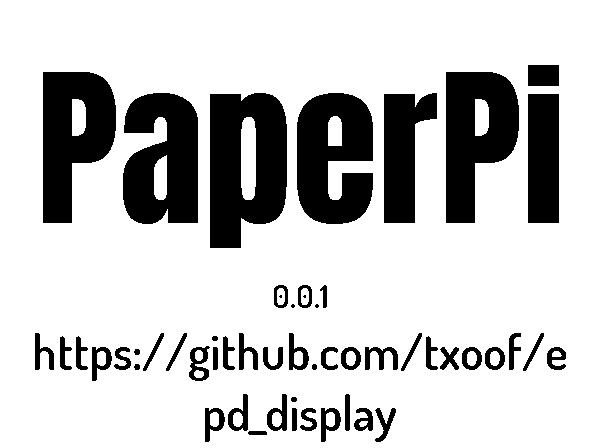

15:27:41 epd5in83:ReadBusy:69:DEBUG - e-Paper busy
15:27:41 epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
15:27:41 Screen:initEPD:337:INFO - <waveshare_epd.epd5in83.EPD object at 0xaf60cc50> initialized
15:27:41 Screen:writeEPD:375:DEBUG - writing to epd
15:27:41 epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
15:27:49 epd5in83:ReadBusy:69:DEBUG - e-Paper busy
15:27:52 epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
15:27:52 epd5in83:ReadBusy:69:DEBUG - e-Paper busy
15:27:52 epd5in83:ReadBusy:72:DEBUG - e-Paper busy release


In [41]:
main()

In [ ]:
epd_module = '.'.join([constants.waveshare_epd, config['main']['display_type']])
epd = import_module(epd_module)
screen = Screen(rotation=config['main']['rotation'])

try:
    screen.epd = epd
except PermissionError as e:
    logging.critical(f'Error initializing EPD interface: {e}')
    logging.critical('The user executing this program does not have access to the SPI devices.')
    do_exit(1, 'This user does not have access to the SPI group\nThis can typically be resolved by running:\n$ sudo groupadd <username> spi')

In [ ]:

if 'splash' in config['main']:
    logging.debug('configuring splash screen')
    if config['main']['splash']:
        from plugins.splash_screen import splash_screen
        splash = True
else:
    splash = None

In [ ]:
splash_config = {
    'name': 'Splash Screen',
    'layout': splash_screen.layout.layout,
    'update_function': splash_screen.update_function,
    'resolution': screen.resolution
}

In [ ]:
cache = CacheFiles(path_prefix=constants.app_name)
# get the expected key-word args from the Plugin() spec
spec_kwargs = getfullargspec(Plugin).args

plugins = []

for section, values in config.items():
    # ignore the other sections
    if section.startswith('Plugin:'):
        logging.info(f'[[ {section} ]]')

        my_config = {}
        # add all the spec_kwargs from the config
        plugin_kwargs = {}
        for key, val in values.items():
            if key in spec_kwargs:
                my_config[key] = val
            else:
                # add everything that is not one of the spec_kwargs to this dict
                plugin_kwargs[key] = val
        
        # populate the kwargs my_config dict that will be passed to the Plugin() object
        my_config['name'] = section
        my_config['resolution'] = screen.resolution
        my_config['config'] = plugin_kwargs
        my_config['cache'] = cache
        try:
            module = import_module(f'{constants.plugins}.{values["plugin"]}')
            my_config['update_function'] = module.update_function
            my_config['layout'] = getattr(module.layout, values['layout'])
        except KeyError as e:
            ## FIX ME -- do a graceful exit here?
            logging.info('no module specified; skipping update_function and layout')
        my_plugin = Plugin(**my_config)
        try:
            my_plugin.update()
        except AttributeError:
            ## FIX ME -- do a graceful exit here?
            logging.info('skipping update due to missing update_function')
        logging.info(f'appending plugin')
        plugins.append(my_plugin)

In [ ]:
## FIX ME Remove this import only for testing in Jupyter
from IPython.display import display
## FIX ME

logging.root.setLevel('WARNING')

if splash:
    splash = Plugin(**splash_config)
    splash.update(constants.app_name, constants.version, constants.url)
    display(splash.image)
    screen.initEPD()
    screen.writeEPD(splash.image)

# use itertools cycle to move between list elements
plugin_cycle = cycle(plugins)
plugin_is_active = False
# current plugin for display
this_plugin = next(plugin_cycle)
# track time plugin is displayed for
this_plugin_timer = Update()
max_priority = -1
# each plugin generates a unique hash whenever it is updated
this_hash = ''

# display_loop_sighandler = SignalHandler()



with InterruptHandler() as h:
    while True:    
        if h.interrupted:
            logging.info('caught interrupt -- stoping execution')
            break
        logging.info('updating plugins')
        priority_list = []

        for plugin in plugins:
            logging.debug(f'[[ {plugin.name} ]]')
            plugin.update()
            # record the priority of all active plugins (priority < 0 is considered inactive)
            if plugin.priority >= 0:
                priority_list.append(plugin.priority)

        # priority increases as it approaches 0; negative priorities are considered inactive        
        max_priority = min(priority_list)
        logging.info(f'current maximum priority: {max_priority}')

        logging.info(f'displaying plugins')
        logging.info(f'[[ {this_plugin.name} ]]')

        if this_plugin_timer.last_updated > this_plugin.min_display_time:
            logging.info(f'this plugin\'s display timer expired; switching plugin')
            plugin_is_active = False

            while not plugin_is_active:
                this_plugin = next(plugin_cycle)
                logging.debug(f'checking priority of {plugin.name}')
                if this_plugin.priority >= 0 and this_plugin.priority <= max_priority:
                    plugin_is_active = True
                else:
                    logging.debug(f'priority is too low: {this_plugin.priority}, max_priority: {max_priority}')
                    plugin_is_active = False                
                    ## this would be a good place to track failed attempts to find a plugin with appropriate
                    ## display value

            logging.debug(f'preparing to display {this_plugin.name}')

            if this_hash != this_plugin.hash:
                logging.debug('plugin image has refreshed -- refreshing screen')
                this_hash = this_plugin.hash
                ## FIX ME! this is where the epdlib.Screen belongs
                display(this_plugin.image)
                screen.initEPD()
                screen.writeEPD(this_plugin.image)
            else:
                logging.debug('plugin image has not refreshed -- skiping screen refresh')
            this_plugin_timer.update()

        ## FIX ME -- find a better way to sleep here?
        sleep(1)
print('cleanup here')
cache.cleanup()
screen.initEPD()
screen.clearEPD()

In [ ]:
splash.update(constants.app_name, constants.version, constants.url)
splash.image
screen.initEPD()
screen.writeEPD(splash.image)

In [ ]:
# config = {
#     'main': {
#         'display_type': 'epd5in83',
#         'splash': True,
#         'rotation': 180,
#     },
#     'Plugin: Clock': {
#         'layout': 'layout',
#         'plugin': 'basic_clock',
#         'refresh_rate': 30,
#         'min_display_time': 10,
#         'max_priority': 1
#     },
#     'Plugin: Word Clock': {
#         'layout': 'word_clock',
#         'plugin': 'word_clock',
#         'refresh_rate': 30,
#         'min_display_time': 10,
#         'max_priority': 1,
#     },
#     'Plugin: Decimal Binary Clock': {
#         'layout': 'dec_binary_clock',
#         'plugin': 'dec_binary_clock',
#         'refresh_rate': 30,
#         'min_display_time': 10,
#         'max_priority': 1,
#     },
#     'Plugin: LMS MacPlay': {
#         'layout': 'twoColumnThreeRows',
#         'plugin': 'lms_client',
#         'refresh_rate': 5,
#         'player_name': 'MacPlay',
#         'min_display_time': 15,
#         'max_priority': 0,
#         'idle_timeout': 10
#     },
#     'Plugin: LibreSpot': {
#         'layout': 'twoColumnThreeRows',
#         'plugin': 'librespot_client',
#         'refresh_rate': 10,
#         'player_name': 'SpoCon-Spotify',
#         'idle_timeout': 15,
#         'max_priority': 0,
#     }
# }


In [ ]:
# my_c = ArgConfigParse.configparser.ConfigParser()


# for s, i in config.items():
#     my_c[s] = {}
#     for j in i:
#         my_c[s][j] = str(i[j])
        

# with open('paperpi.ini', 'w') as cf:
#     my_c.write(cf)

# # logging.root.setLevel('DEBUG')
# logging.root.setLevel('INFO')